___
___
___


# **Datenanalyse & Forecasting & pyWATTS Übung 2023**

___
___
___



# **1. Introduction**

Welcome to our exercise notebook on data analysis and time series forecasting with Pywatts! This notebook will explore some tools for analyzing data and further show a small pipline approach forecasting future values using Pywatts, a pipeline based library for time series forecasting. This notebook will provide you with some insights and hands-on experience in working with time series data. Therefore, let's get started and dive into the exciting world of data analysis and time series forecasting with Pywatts!

Please note it is mandatory to install all the required software and packages using the guide provided in Ilias before proceeding with this exercise notebook. The guide contains important instructions how to properly set up your environment. This ensures that all the necessary dependencies are installed. Failure to follow the instructions may result in errors or unexpected behavior while working through the notebook.

This is an interactive notebook and also includes some work assignments. Typical tasks are adding lines of code, documenting observations. Work orders are always marked in the color <span style="color:#A00000"> **red** </span>.


___

## Agenda 

1. Introduction, Agenda, learning goals and data loading

2. Data Analysis

3. Pywatts Excercise

___


##  Learning goals (sorted by chapter)

### Learning goals data analysis and time series analysis

    - item 1
    - tiem 2
    - item 3

### Learning goals machine learning process with pyWATTS

    - item 1
    - tiem 2
    - item 3

___




## Data loading and first preprocessing
As a basis for the data analysis we need data in the first place. This publically available data set is described here: [Full Dataset Introduction](https://data.open-power-system-data.org/household_data/2020-04-15)

Here we have taken only a subset of the data, since we want to deal with only one building. Our choice is the industrial building 3. All the data is scaled in kWh.



In [17]:
import pandas as pd
import statsmodels.api as sm
import pylab

# Basic configuration to get beautiful pictures 
pylab.rcParams['figure.figsize'] = (16, 9)

# Load the data
date_parser = lambda date: pd.Timestamp(pd.to_datetime(date, format= '%Y-%m-%dT%H:%M:%SZ'))
data = pd.read_csv("data/household_data_15min_singleindex_filtered-2.csv", index_col="utc_timestamp", parse_dates=True ,date_parser=date_parser, sep=',')

# Get the relevant data for this excercise and resample it to hourly resolution to save runtime complexity
data["demand"] = data["DE_KN_industrial3_grid_import"].diff(1).resample("1h").mean()
data["solar"] = data["DE_KN_industrial3_pv_roof"].diff(1).resample("1h").mean()

# Omit data without values
data = data[["demand","solar"]].dropna()
# Let the data start with a full day
data =  data[data.index >= pd.to_datetime("2016-11-03")]

# **2. Data Analysis**

<img src="images/data_trap.png" width="400" height="400">

[This xkcd comic you can find here](https://xkcd.com/2582/)

Within the data analysis chapter, we will first use simple tools from Pandas to get an overview of the data set.
After that, we will make a daily observation of the load, in addition to this we want to seperate watch on the differenc between a weekday and weekend.
In the last part we will use more complex tools like autocorellation plots and a seasonal decomposition to identify properties like trend and seasonality in our time series.


First of all, we would like to show you three very simple functions that Pandas has ready for you :

## Warmup and get familiar with the data:

1. head() First five rows of the data set. Commonly used as a sanity check to see how the Data is constructed. 
2. describe() Provides basic satistical values of the dataset. For example, mean, standard deviation and quantiles.
3. plot() The plot function draws a simple plot over all collumns of the given dataset with mathplolib.

### <span style="color:#A00000"> Use the three functions (head, describe and plot) below! </span>



In [2]:
# Use the head function

data.head()

,demand,solar
utc_timestamp,,
2016-11-03 01:00:00,15.1875,0.0
2016-11-03 02:00:00,15.0000,0.0
2016-11-03 03:00:00,14.8125,0.0
2016-11-03 04:00:00,14.4375,0.0
2016-11-03 05:00:00,15.3750,0.0


In [3]:
# Use the describe function
data.describe()

,demand,solar
count,5134.000000,5134.000000
mean,19.415819,0.289401
std,8.710133,0.594947
min,3.750000,0.000000
25%,14.187500,0.000000
50%,14.875000,0.000000
75%,23.500000,0.230225
max,50.187500,2.775391


<Axes: xlabel='utc_timestamp'>

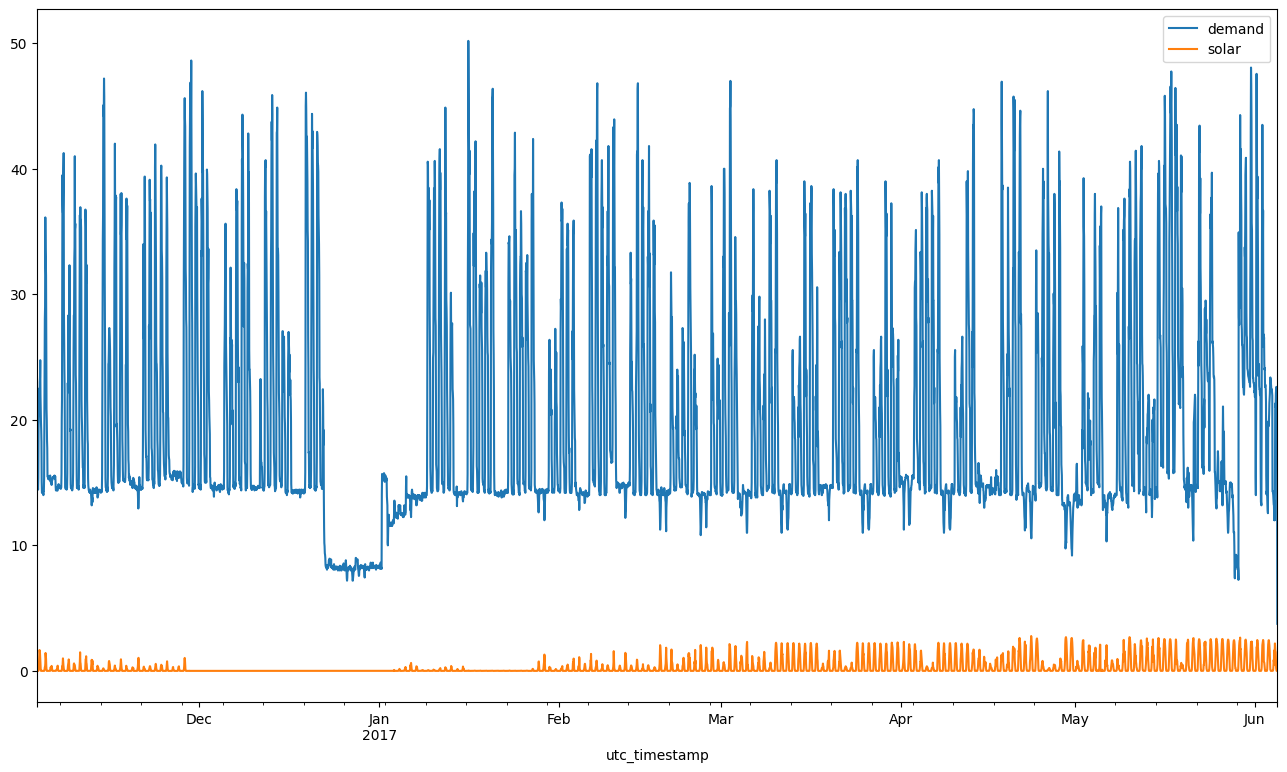

In [4]:
# Use the plot function
data.plot()

 ### <span style="color:#A00000 "> Point out two observations about the given data! </span>

1. < Observation 1 >
2. < Observation 2 >

## Daily observations and comparison between weekdays and weekends

<Axes: xlabel='hour'>

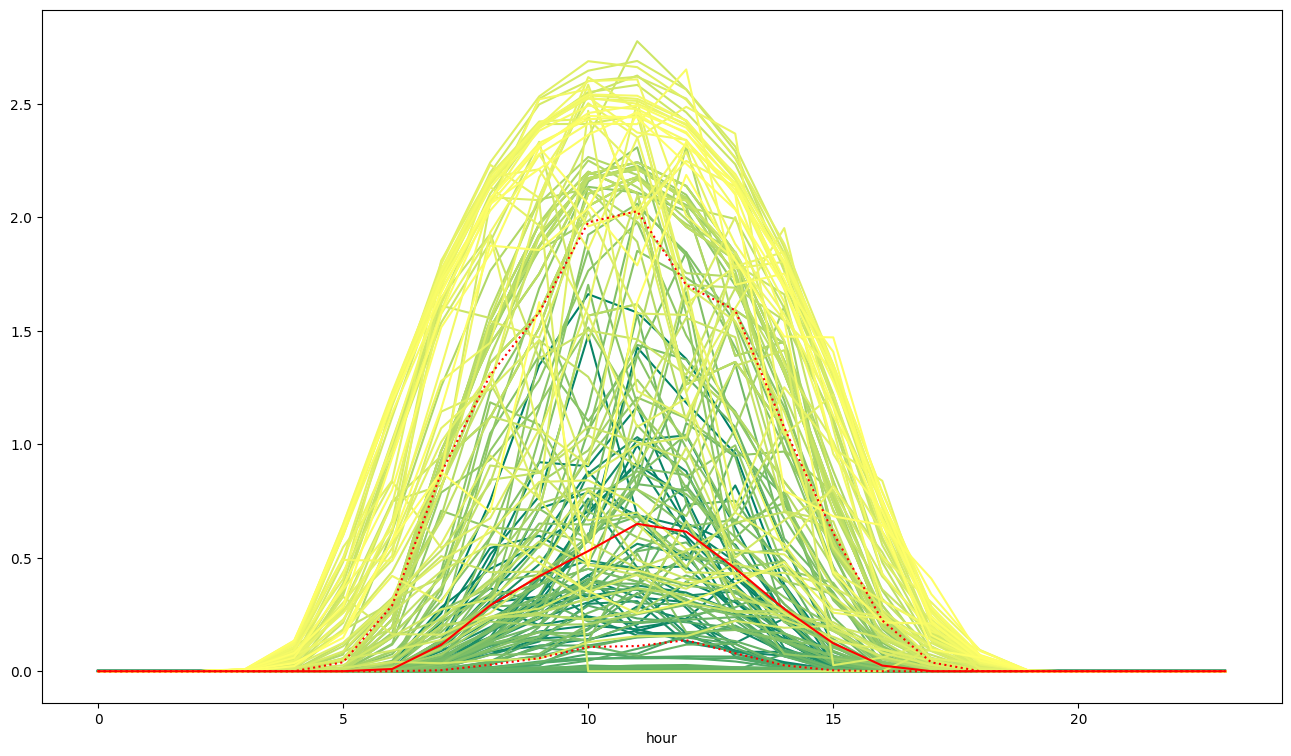

In [29]:
# Calculating the hour of the day the weekday and the day since the beginning of the time series to create the pivot table
data["hour"] = data.index.hour.values
data["weekday"] = data.index.weekday.values
data["month"] = data.index.month.values
data["days_since_start"] = [int(x/(24)) for x in range(0,len(data))]

pivot_solar = pd.pivot_table(data, index=['hour'],columns=['days_since_start'], values=['solar'])
pivot_solar["solar"].plot(legend=False,colormap="summer")

pivot_solar.median(axis=1).plot(color="red")
pivot_solar.quantile(0.25,axis=1).plot(color="red",linestyle='dotted')
pivot_solar.quantile(0.75,axis=1).plot(color="red",linestyle='dotted')

#### Workingdays

days_since_start,0,1,4,5,6,7,8,11,12,13,...,200,201,202,203,204,207,208,209,210,211
hour,,,,,,,,,,,,,,,,,,,,,
0,15.0000,14.1875,14.6250,14.6250,14.6250,14.5625,14.5625,14.1875,14.4375,14.9375,...,14.8125,16.1875,23.6250,23.4375,14.3125,8.250000,22.6250,23.2500,22.3125,21.8125
1,15.1875,14.1875,14.6250,14.5625,14.3750,14.6250,14.8125,14.3750,14.2500,14.5000,...,14.8125,16.4375,23.6875,23.1875,14.5000,8.375000,23.0000,23.1250,21.8125,16.0625
2,15.0000,14.0000,14.5000,14.4375,14.4375,14.6250,14.6250,14.3125,14.3125,14.6875,...,14.6250,16.1875,23.1875,21.3125,14.3125,8.062500,22.5000,23.0000,21.8750,13.4375
3,14.8125,14.3125,14.5625,14.5625,14.5625,14.7500,14.8125,14.4375,14.6250,14.5000,...,14.5625,16.3125,20.8125,15.8125,14.5000,8.312500,22.1250,23.0000,22.0000,13.3750
4,14.4375,14.3125,14.6250,14.5625,14.7500,14.4375,14.5625,14.2500,14.3125,14.3750,...,14.6250,16.0625,16.0000,15.8125,14.3750,8.000000,22.0000,23.0000,15.5000,13.1875
5,15.3750,15.3750,15.6875,15.7500,15.7500,15.3750,15.0000,15.6250,15.5000,15.4375,...,14.5625,15.6875,15.9375,15.3125,14.8125,7.250000,22.7500,22.6250,14.0000,19.9375
6,19.3125,19.5000,20.0000,21.6875,21.8125,18.1250,18.8750,22.2500,21.1875,16.3750,...,19.5625,21.0000,23.5000,14.6875,15.9375,34.937500,25.1250,30.3750,20.1250,31.3750
7,20.3750,22.6250,21.6250,22.9375,25.5000,23.6875,26.7500,29.0000,24.4375,22.6250,...,26.2500,21.6250,27.6250,13.8750,16.6875,28.187500,33.7500,33.5000,41.4375,36.3125
8,22.1250,28.0000,32.3750,22.1875,28.3125,30.0000,36.7500,34.3750,24.5625,32.1875,...,24.3125,19.3750,32.7500,13.3125,16.3750,27.562500,33.0000,43.2500,47.5625,43.5000


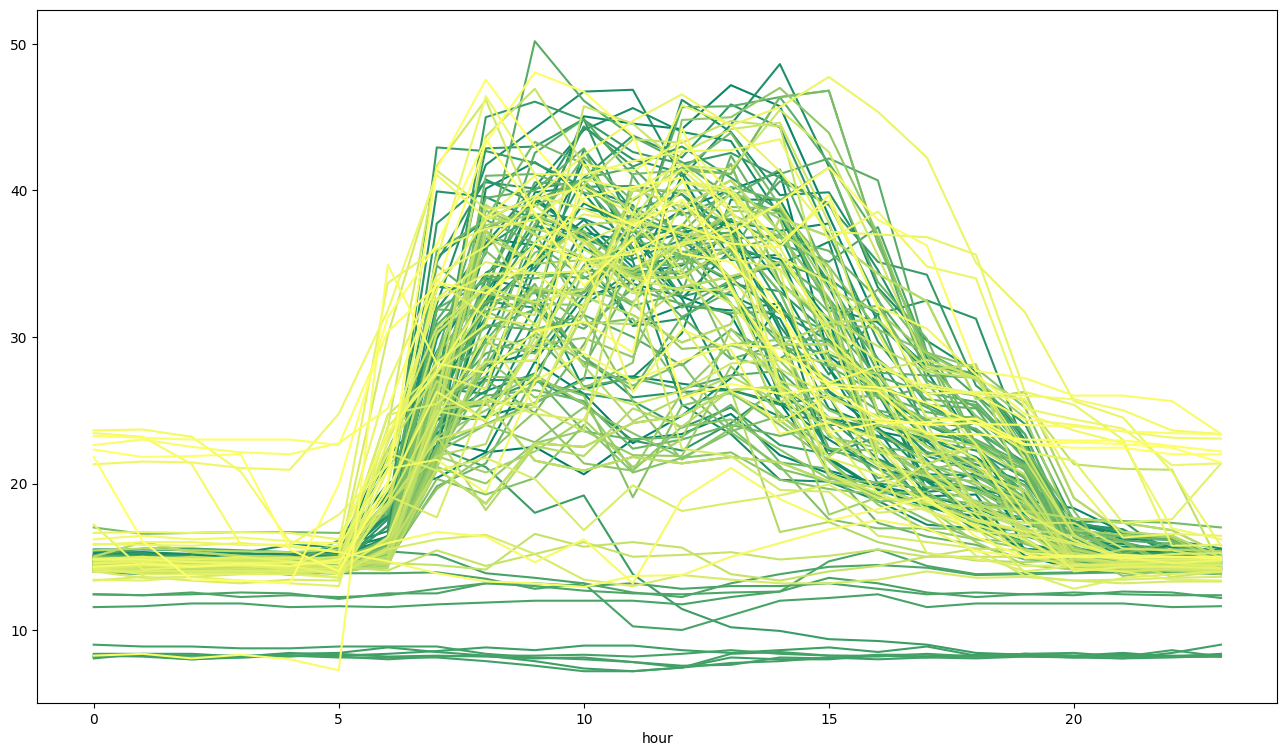

In [18]:
# Calculating the hour of the day the weekday and the day since the beginning of the time series to create the pivot table
data["hour"] = data.index.hour.values
data["weekday"] = data.index.weekday.values
data["days_since_start"] = [int(x/(24)) for x in range(0,len(data))]

pivot_workingdays = pd.pivot_table(data[data["weekday"] < 5], index=['hour'],columns=['days_since_start'], values=['demand'])
pivot_workingdays["demand"].plot(legend=False,colormap="summer")



#### Weekend

<Axes: xlabel='hour'>

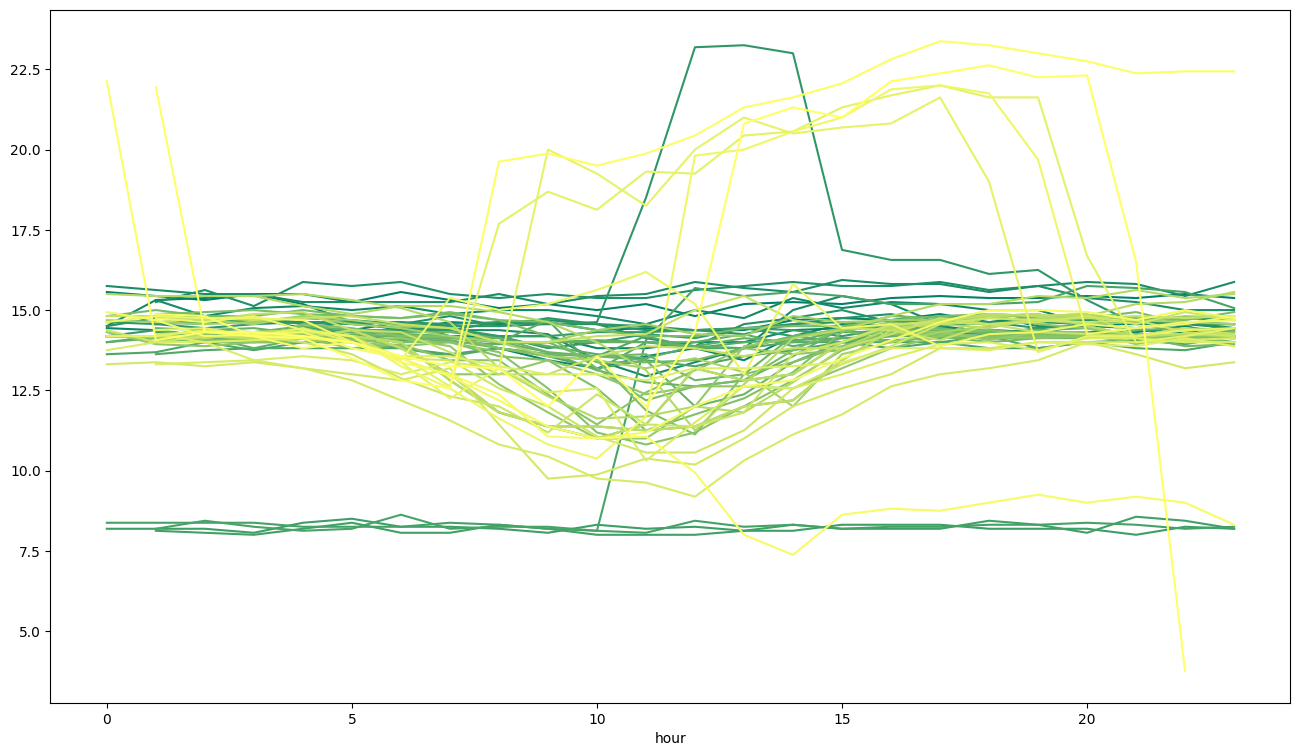

In [6]:

pivot_weekends = pd.pivot_table(data[data["weekday"] >= 5], index=['hour'],columns=['days_since_start'], values=['demand'])
pivot_weekends["demand"].plot(legend=False,colormap="summer")


<Axes: xlabel='hour'>

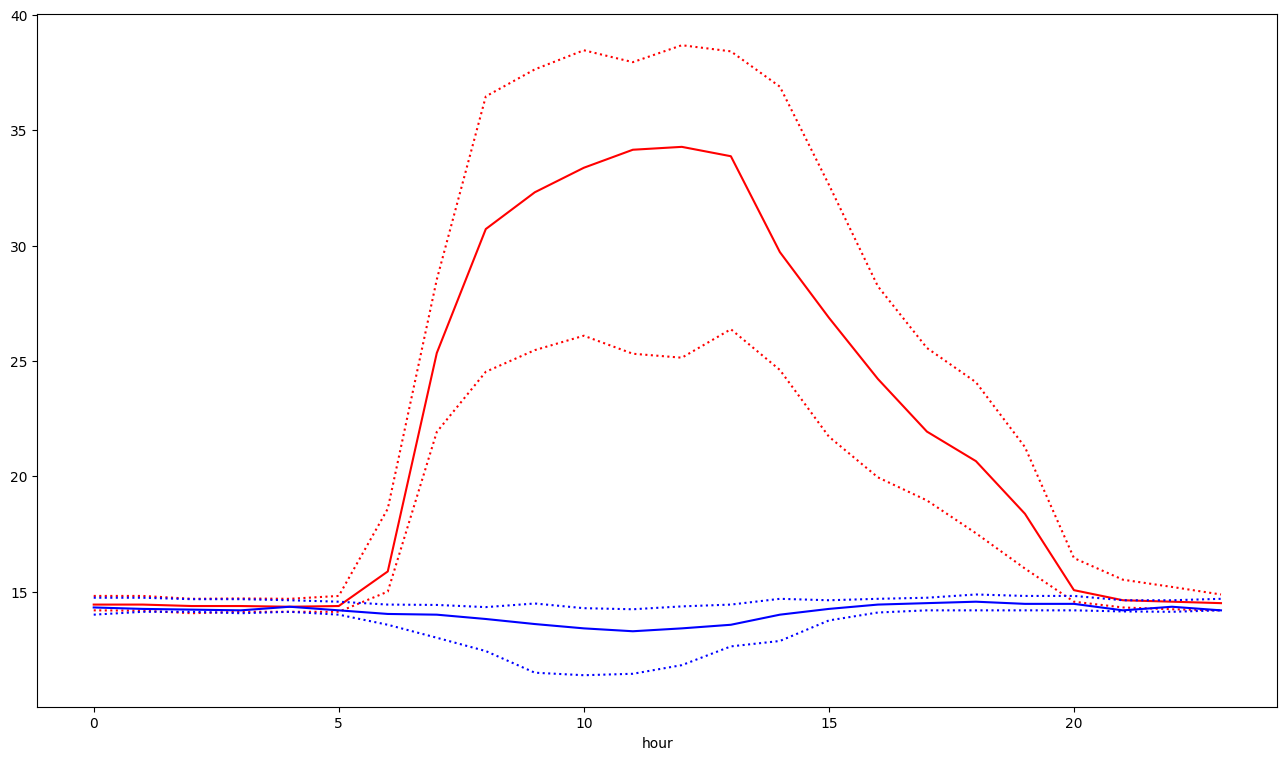

In [7]:
#
# Plot the median of all weekdays 
#

pivot_workingdays.median(axis=1).plot(color="red")
pivot_workingdays.quantile(0.25,axis=1).plot(color="red",linestyle='dotted')
pivot_workingdays.quantile(0.75,axis=1).plot(color="red",linestyle='dotted')
pivot_weekends.median(axis=1).plot(color="blue")
pivot_weekends.quantile(0.25,axis=1).plot(color="blue",linestyle='dotted')
pivot_weekends.quantile(0.75,axis=1).plot(color="blue",linestyle='dotted')

1. < Observation 1 >
2. < Observation 2 >

### ACF Plot

### Seasonal Decomposition

Can be found here: 
https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

The additive model is $Y[t] = T[t] + S[t] + e[t]$

The results are obtained by first estimating the trend by applying a convolution filter to the data. The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.

#### Visualisation Demand

##### Key Obervations :

- Weekly Pattern visible through the seasonal component Plot 168
- Daily Pattern visble through the seasonal component Plot 24


#### Demand ACF

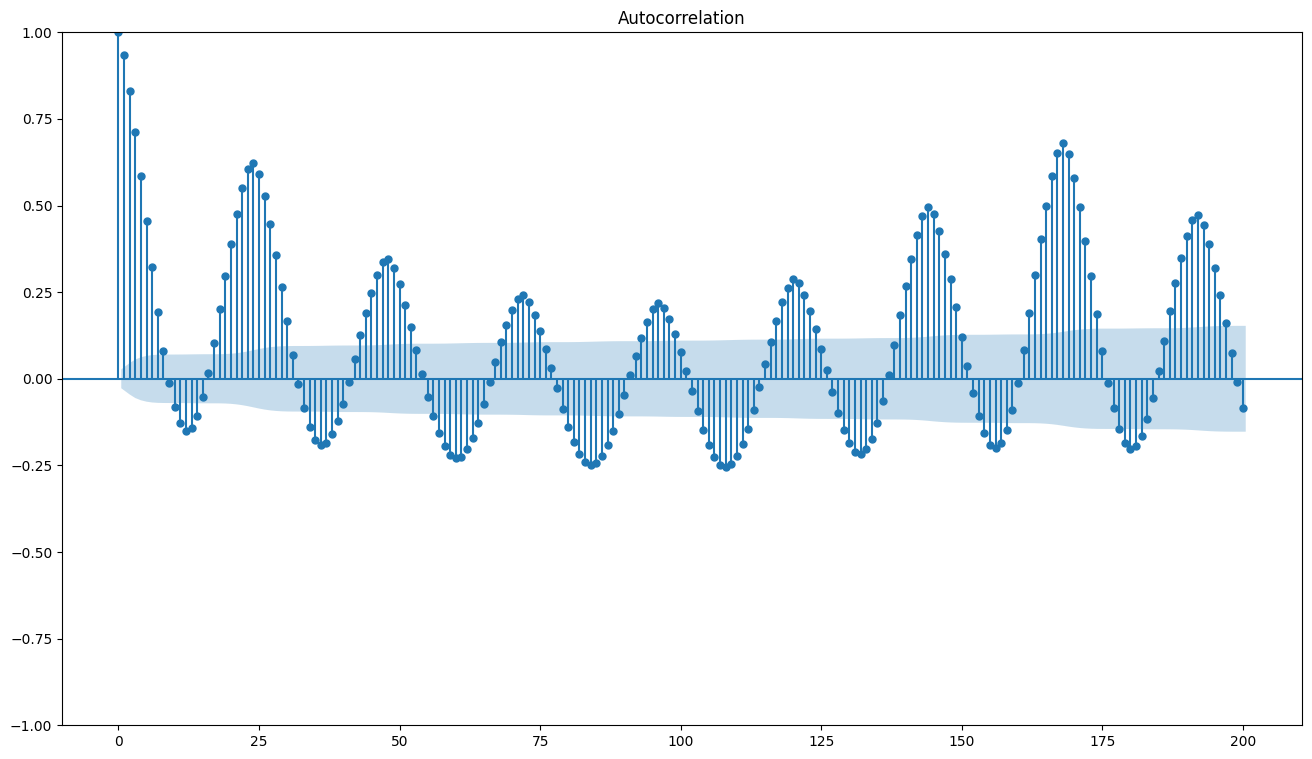

In [8]:
res = sm.tsa.graphics.plot_acf(data["demand"], lags= 200)

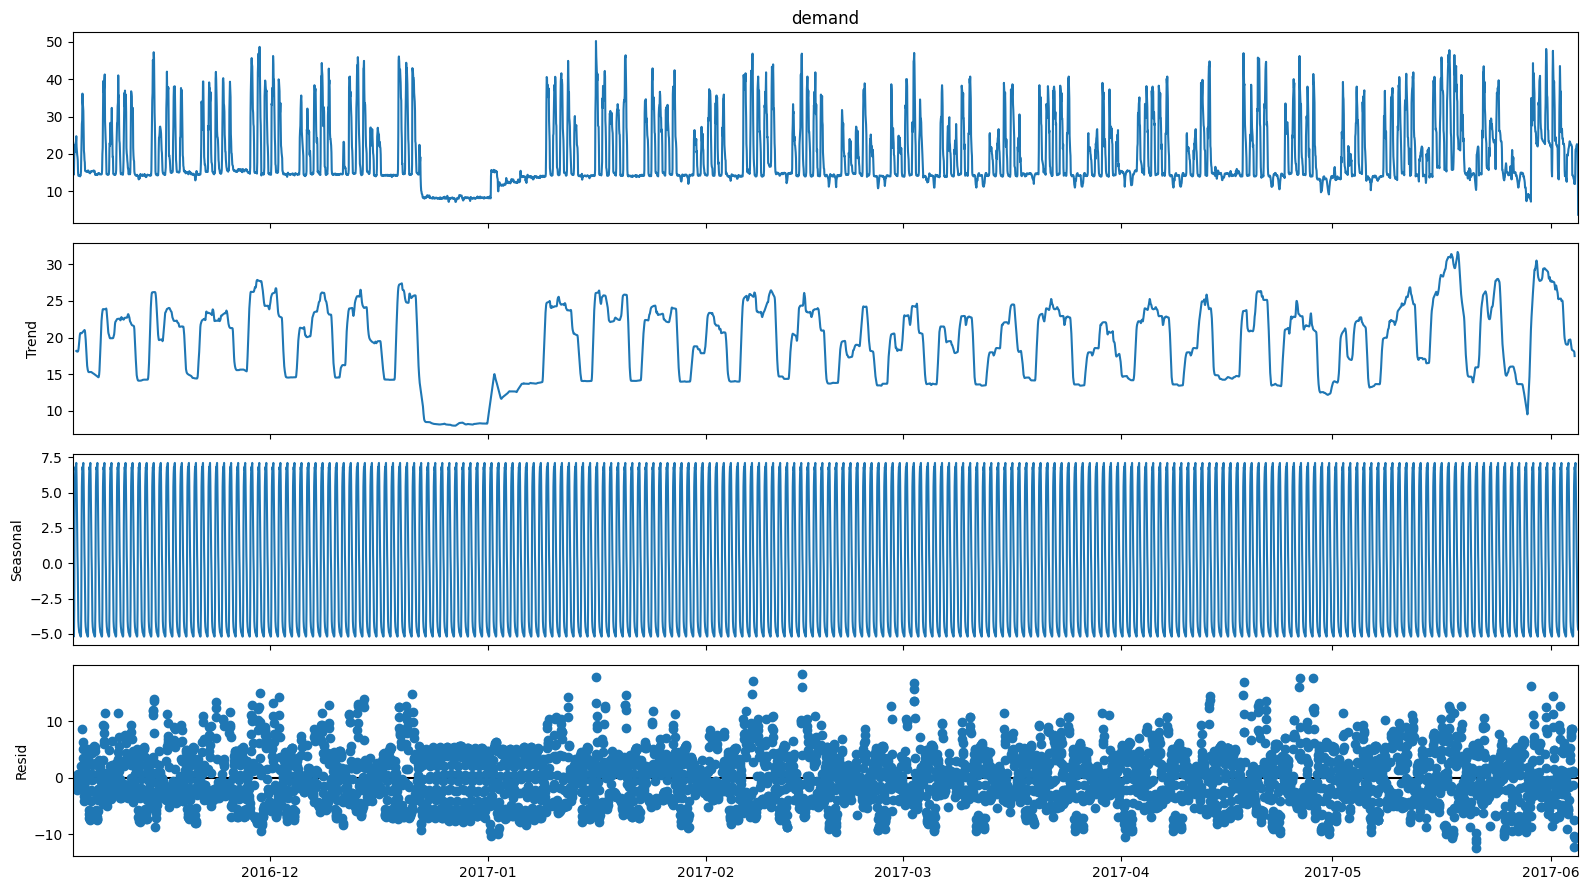

In [9]:
res = sm.tsa.seasonal_decompose(data["demand"][:], period= 24)
resplot = res.plot()

#### Demand - a dailiy pattern

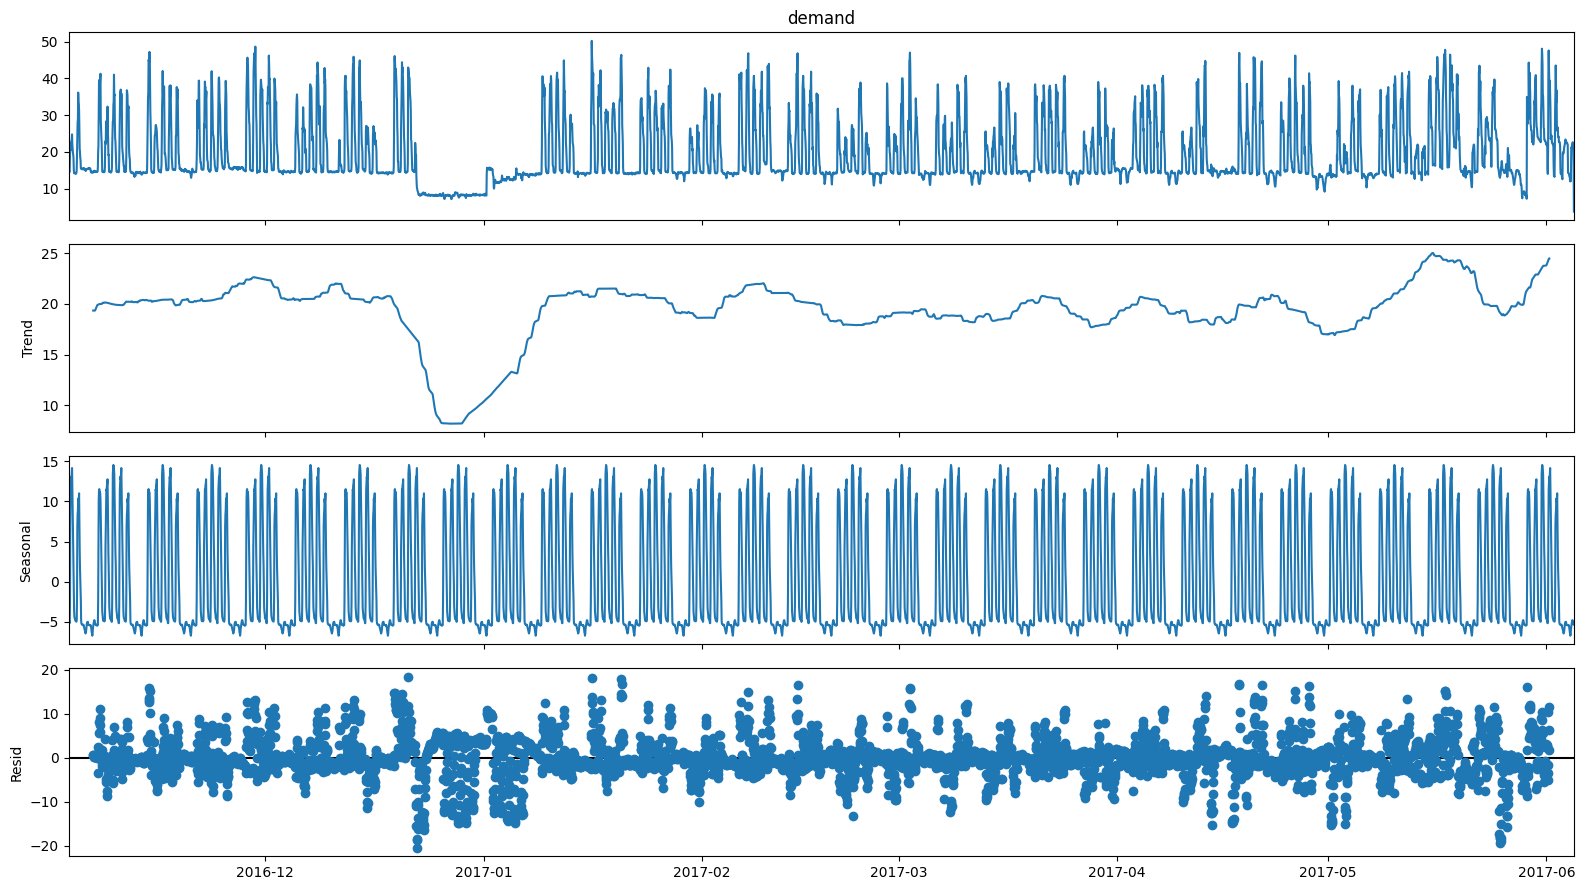

In [10]:
res = sm.tsa.seasonal_decompose(data["demand"][:], period=168)
resplot = res.plot()

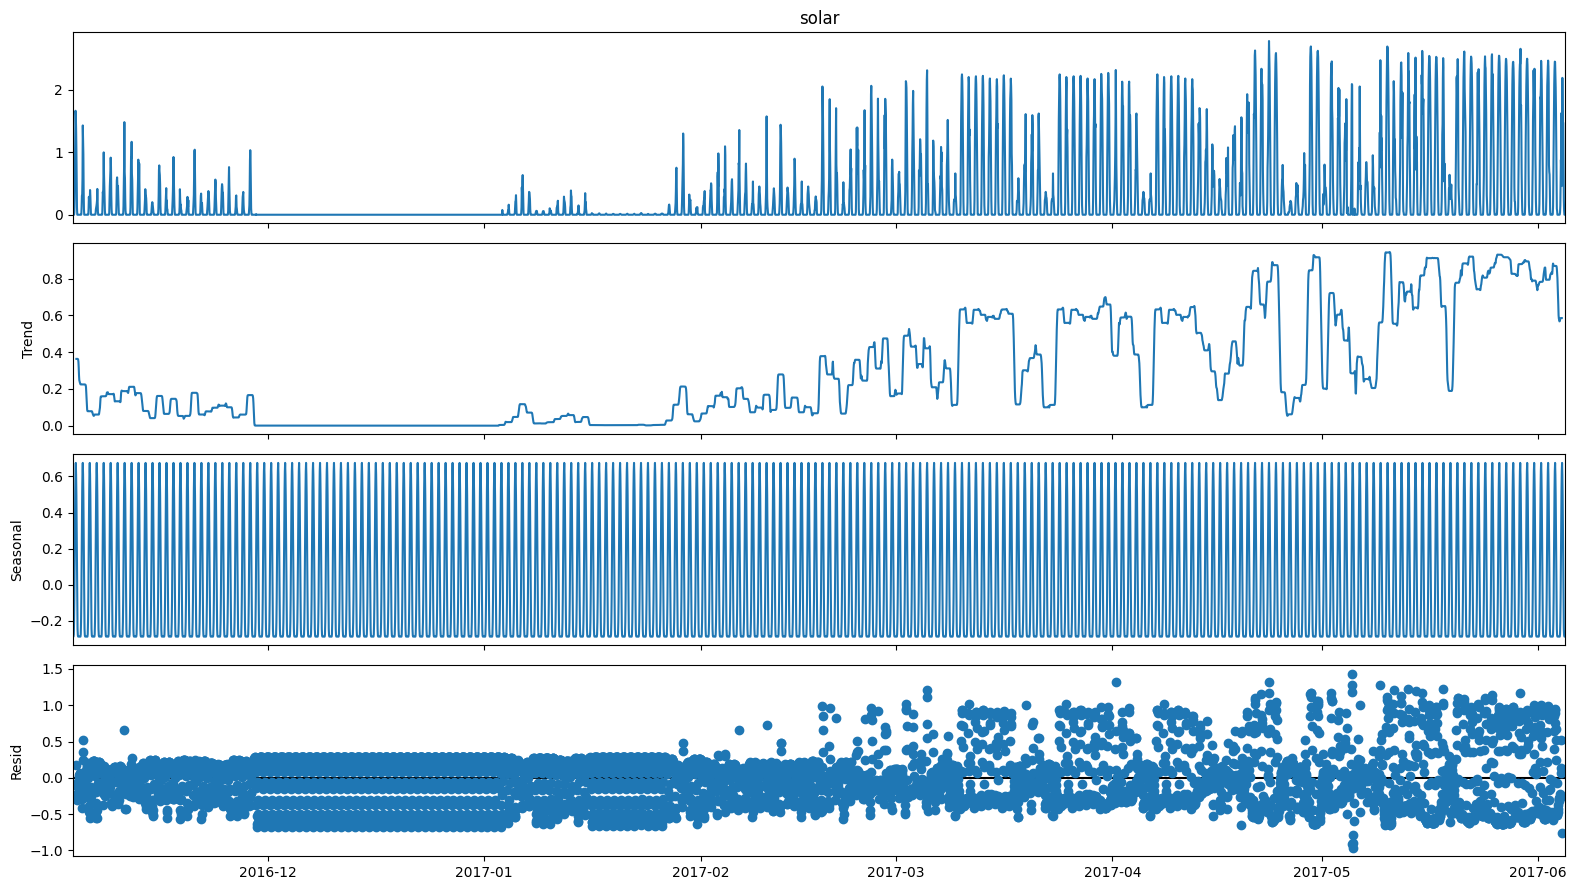

In [11]:
res = sm.tsa.seasonal_decompose(data["solar"][:], period=24)
resplot = res.plot()

## Forecasting with pyWatts

In this section of the Jupyter Notebook, you will learn about using pyWatts to perform time series forecasting. Time series forecasting is a technique used to predict future values of a variable based on historical data. It can be useful in many fields, such as finance, economics, and engineering.

But first of all what is pyWatts: 

### Chat GPT - What is Pywatts?
#### Chat GPT's Opinion

>“Pywatts is an open-source Python library designed to simplify time series analysis. It provides users with a range of powerful tools for exploring, visualizing, and modeling time series data. Pywatts is particularly useful for tasks such as forecasting, anomaly detection, and data preprocessing. The library includes a wide range of functionality, including a suite of built-in data loaders for importing time series data from a variety of sources, such as CSV files, databases, and web APIs. Pywatts also includes a range of data preprocessing tools, such as resampling, interpolation, and feature engineering, that can help users to prepare their time series data for analysis. One of the key features of Pywatts is its support for a range of machine learning models for time series analysis. These models include popular algorithms such as ARIMA, LSTM, and GRU models, as well as models for anomaly detection, such as isolation forests and one-class SVMs. Pywatts also provides tools for model training, evaluation, and deployment, making it an ideal platform for both research and production environments. Pywatts is designed to be easy to use, with a simple and intuitive interface that makes it accessible to users with a wide range of backgrounds and skill levels. The library is actively maintained and supported by a community of developers, ensuring that it is up-to-date and compatible with the latest versions of Python and other libraries. Overall, Pywatts is a powerful and flexible tool for anyone working with time series data. Whether you are a researcher, analyst, or data scientist, Pywatts can help you to quickly and easily preprocess, analyze, and model your time series data, enabling you to gain valuable insights and make informed decisions.“

#### What is right what is wrong ? 

- data loaders gibt es nicht
- feature engineering ja so halbe
- ARIMA, naja über statsmodels halt aber das funktioniert eher schlecht
- Die ganzen modelle kommen halt über third party libraries rein.
- Production environment NEIN!
- Keine community of developers 













The section walks you through the creation of a pipeline for time series forecasting. The pipeline includes several steps, such as data preprocessing, model selection, and evaluation. By following the steps in the pipeline, you will learn how to create a 24-hour ahead forecast, which is the prediction of the value of a variable 24 hours into the future based on historical data. Visible in this figure:

# Todo here not only a 24 hour ahead forecast is done further a forecust upt a 24 hour ahead forecast.

<img src="images/24_hours_ahead_forecast_2.png" width="800" height="300">

To evaluate the accuracy of the forecast, the section provides various metrics, such as mean absolute error and root mean squared error. These metrics allow you to understand how close the forecasted values are to the actual values. Those Metrics are introduced here:


MAE = $\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})$


RMSE = $\sqrt{\frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2}$


To help with the interpretation of the results, the section includes visualizations of the forecasted values and actual values over time. These visualizations can help you identify trends and patterns that may not be immediately apparent from the metrics alone.

Overall, this section provides a practical introduction to using pyWatts for time series forecasting. By the end of the section, you will have a good understanding of the pipeline for time series forecasting and how to evaluate the accuracy of your forecasts.

In [12]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.util.computation_mode import ComputationMode

from pywatts.modules import SKLearnWrapper
from pywatts.modules.preprocessing.select import Select
from pywatts.modules.wrappers import FunctionModule
from pywatts.modules.feature_extraction.calendar_extraction import CalendarExtraction, CalendarFeature
from pywatts.summaries import RMSE, MAE




def get_forecasting_pipeline(forecast_horizon, historical_features,scope_var,sklearn_wrappers):


    forecast_pipeline = Pipeline(f"results/")


    calendar = CalendarExtraction('calendar',continent="Europe", country="Germany",
                                           features=[CalendarFeature.month_sine, CalendarFeature.month_cos,
                                                    CalendarFeature.weekday_sine, CalendarFeature.weekday_cos,
                                                    CalendarFeature.workday, CalendarFeature.holiday, CalendarFeature.hour_cos, CalendarFeature.hour_sine])(x=forecast_pipeline[scope_var])

    data_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler")
    data_scaled = data_scaler(x=forecast_pipeline[scope_var])

    features_scaled = Select(start=-historical_features, stop=0, step=1, name="Sample_historical_features")(x=data_scaled)
    target_scaled = Select(start=0, stop=forecast_horizon, step=1, name="Sample_targets")(x=data_scaled)
    calendar_selected = Select(start=0, stop=forecast_horizon, step=1, name="Sample_calendar")(x=calendar)

    

    result_dict= {}
    result_dict_unscaled = {}
    target = data_scaler(x=target_scaled, computation_mode=ComputationMode.Transform, method="inverse_transform")
    FunctionModule(lambda x:x, name='target')(x=target)
    
    for forecaster in sklearn_wrappers:
        result_dict[forecaster.name] = forecaster(
        features=features_scaled,
        calendar=calendar_selected,
        target=target_scaled,
        )

        result_dict_unscaled[forecaster.name] = data_scaler(x=result_dict[forecaster.name], computation_mode=ComputationMode.Transform,method="inverse_transform")
        FunctionModule(lambda x:x, name='forecast_' + forecaster.name)(x=result_dict_unscaled[forecaster.name])
        

        rmse = RMSE(name="rmse_" + forecaster.name)(y_hat=result_dict_unscaled[forecaster.name] , y=target)
        mae = MAE(name="mae_" + forecaster.name)(y_hat=result_dict_unscaled[forecaster.name] , y=target)

    return forecast_pipeline



/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-packages/pywatts_pipeline/core/transformer/base.py:195: UserWarning: The step with name scaler is renamed to scaler_1 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-packages/pywatts_pipeline/core/transformer/base.py:195: UserWarning: The step with name scaler is renamed to scaler_2 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
/Users/hp5743/miniforge3/envs/uebung_2023_pyWatts/lib/python3.10/site-packages/pywatts_pipeline/core/transformer/base.py:195: UserWarning: The step with name scaler is renamed to scaler_3 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")


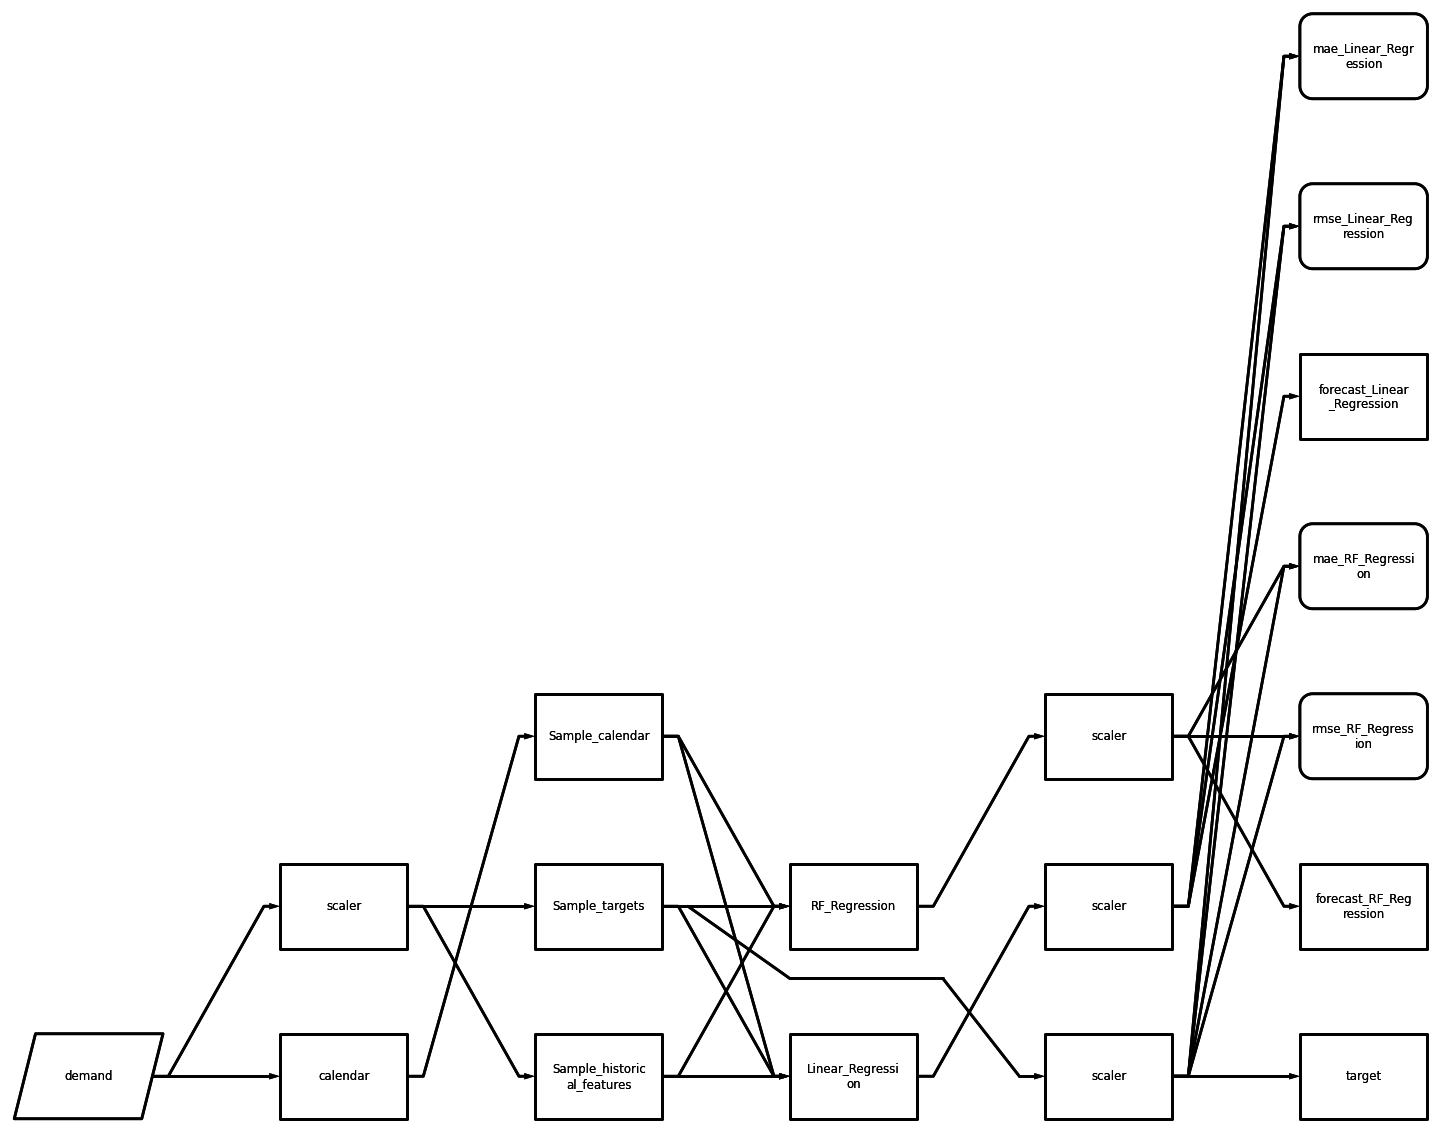

In [13]:
SCOPE_VARIABLE =  ["demand"]
TRAINING_END = pd.Timestamp("2017-03-01")



forecasters = [ SKLearnWrapper(module=RandomForestRegressor(), name="RF_Regression"),
                SKLearnWrapper(module=LinearRegression(), name="Linear_Regression")
                ]

training_data = data[SCOPE_VARIABLE][:TRAINING_END]
testing_data = data[SCOPE_VARIABLE][TRAINING_END:]


pipeline = get_forecasting_pipeline(24,24,"demand",forecasters)


res_train , summary_train  = pipeline.train(training_data)

res_test , summary_test  = pipeline.test(testing_data)


drawing = pipeline.draw()
drawing.draw()








# Result Visualisation

The basic functionality to acess the metrics in pyWATTS is called Summary. They get saved in the result files. 

In [14]:
print(summary_test)

# Summary: 
## Summary
### rmse_RF_Regression

* y_hat : 4.698083016526113
### mae_RF_Regression

* y_hat : 2.8557385651516585
### rmse_Linear_Regression

* y_hat : 5.09864985010721
### mae_Linear_Regression

* y_hat : 3.877007852310702
## FitTime
### calendar Training Time

*  : 9.5367431640625e-07
### scaler Training Time

*  : 0.00024175643920898438
### Sample_historical_features Training Time

*  : 2.86102294921875e-06
### Sample_targets Training Time

*  : 9.5367431640625e-07
### Sample_calendar Training Time

*  : 0.0
### target Training Time

*  : 1.1920928955078125e-06
### RF_Regression Training Time

*  : 8.530249118804932
### forecast_RF_Regression Training Time

*  : 1.9073486328125e-06
### Linear_Regression Training Time

*  : 0.03736090660095215
### forecast_Linear_Regression Training Time

*  : 9.5367431640625e-07
## TransformTime
### calendar Transform Time

*  : 0.019763946533203125
### scaler Transform Time

*  : 0.0003018379211425781
### Sample_historical_features Tra

In [15]:
# Todo Some fancy Plots 







# Plot Prediction vs Reality in different Models


# Plot Maybe public holiday 


# Weiterführende Links

- Beispiele Forschung mit Pywatts
- DERs Repo Verlinken

<img src="images/machine_learning.png" width="600" height="800">

[This xkcd comic you can find here](https://xkcd.com/1838/)

Backlog:


### Lernblock Vorhersagen mit Pywatts

#### Lernziele Forecast

- Test Train (Val) Splitting soll beschieben werden können
- Skalieren ? Eventuell nehm ich das noch raus, da nur das NN davon profitiert vs. simplicity

### Lernziele Machine Learning Process

- Sinn und Zweck von verschiedenen Schritten des Machine Learning Process (datenanalyse , preoprocessing, modelle , postprocessing, evaluation)

#### Lernziele Pywatts: 

- Eigenschaften und Vorteile eines Pipline basierten Ansatzes sollen beschrieben werden können.
- Das bedienen einer Pipeline zur Erstellung von einfachen Vorhersagen
- 

### Lernblock Zeitreihenanalyse

#### Lernziele: 

Grundlegende Eigenschaften von Zeitreihen sollen beschrieben werden können werden können.

- Granularität
- Dimensionalität ?
- Statistische Auswertung über describe ?

- Stationarität ?
- Saisonalität
- Trend
- Bedeutung und Relevanz von kalendarischen Features im Kontext von Energiezeitreihen
- Interpretation eines Tagesmusters

Einfach tools wie sm.seasonal.decomposition sollen bedient werden können und die Ergebnisse eingeordnet werden können